In [130]:
## Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from selenium import webdriver
import json
import string
from colour import Color
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from time import sleep

## Connect Chrome Driver
driver = webdriver.Chrome('/Users/joel/selenium_drivers/chromedriver 3')

## Scraping Code

driver.get('https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w/htmlview?sle=true#')
sleep(3)
driver.find_element_by_partial_link_text('States daily').click()
table = driver.find_element_by_xpath('//*[@id="916628299"]/div/table/tbody')
rows = table.find_elements_by_tag_name('tr')
columns = rows[0].find_elements_by_tag_name('td')
rows = rows[2:]

## Update Data
with open('coronavirus.json') as f:
    data = json.load(f)
    state = data['state']

    date_  = []
    state_ = []
    positive_ = []
    negative_ = []
    pending_ = []
    hospitalization_ = []
    death_ = []
    total_ = []
    
    for row in rows:
        cells = row.find_elements_by_tag_name('td')

        date_ob = cells[0].text
        state_ob= cells[1].text
        positive_ob = cells[2].text
        negative_ob = cells[3].text
        pending_ob = cells[4].text
        hosp_ob = cells[5].text
        death_ob = cells[6].text
        total_ob = cells[7].text
        if not hosp_ob:
            hosp_ob = ''

        date_.append(date_ob)
        state_.append(state_ob)
        positive_.append(positive_ob)
        negative_.append(negative_ob)
        pending_.append(pending_ob)
        hospitalization_.append(hosp_ob)
        death_.append(death_ob)
        total_.append(total_ob)
        
    state['Date'] = date_
    state['State'] = state_
    state['Positive'] = positive_
    state['Negative'] = negative_
    state['Pending'] = pending_
    state['Hospitalized'] = hospitalization_
    state['Deaths'] = death_ 
    state['Total'] = total_

## Save Data
with open('coronavirus.json', mode='w', encoding='utf-8') as f:
    json.dump(data, f)


## Create Daily Aggregate Data   
with open('coronavirus.json') as f:
    data = json.load(f)
    state = data['state']


df = pd.DataFrame(state)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

for column in df.columns:
    df[column] = df[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

df = df.replace('', np.nan)

columns = df.columns

columns = columns.drop('State')

for column in columns:
    df[column] = df[column].astype(float)

grouped = df.groupby(pd.Grouper(freq='D')).sum()

collected = []
for idx in grouped.index.unique():
    day = df.loc[idx]
    count = len(day[day.Positive > 0])
    collected.append(count)

grouped['state_count'] = collected


data['daily_summary']['Date'] = ['{}/{}/{}'.format(x.month,x.day, x.year) for x in grouped.index]
data['daily_summary']['Positive'] = grouped.Positive.tolist()
data['daily_summary']['Negative'] = grouped.Negative.tolist()
data['daily_summary']['Pending'] = grouped.Pending.tolist()
data['daily_summary']['Hospitalized'] = grouped.Hospitalized.tolist()
data['daily_summary']['Total'] = grouped.Total.tolist()
data['daily_summary']['Confirmed States'] = grouped.state_count.tolist()

with open('coronavirus.json', mode='w', encoding='utf-8') as f:
    json.dump(data, f)

In [158]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

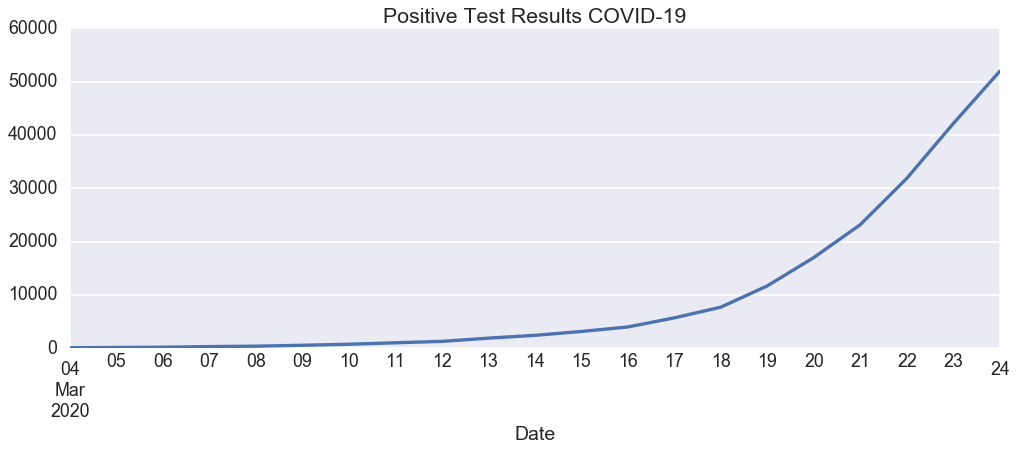

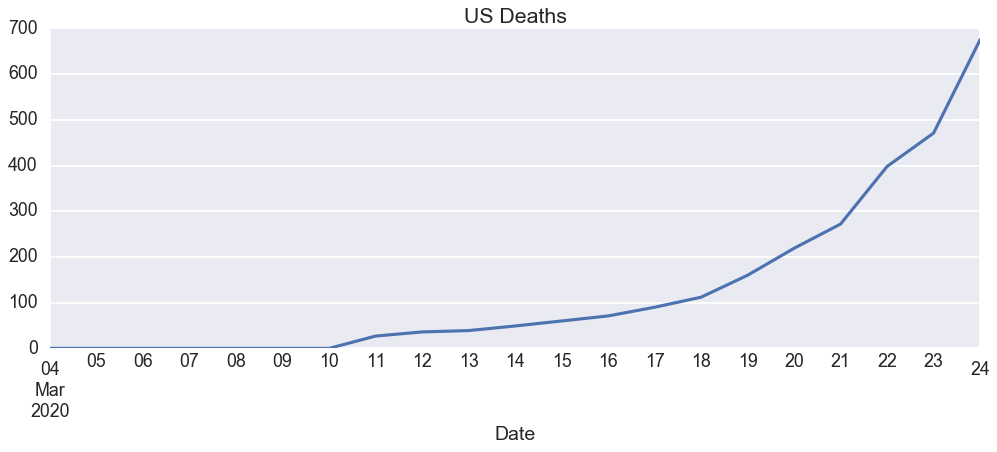

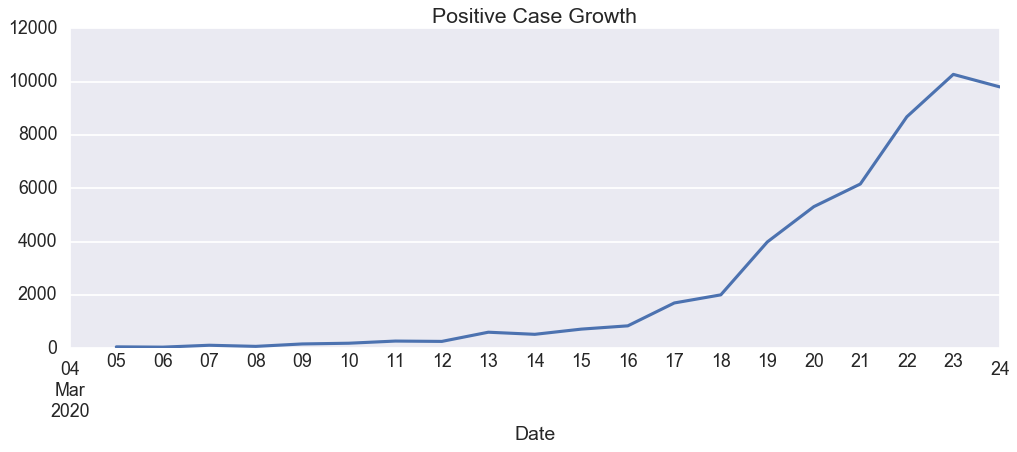

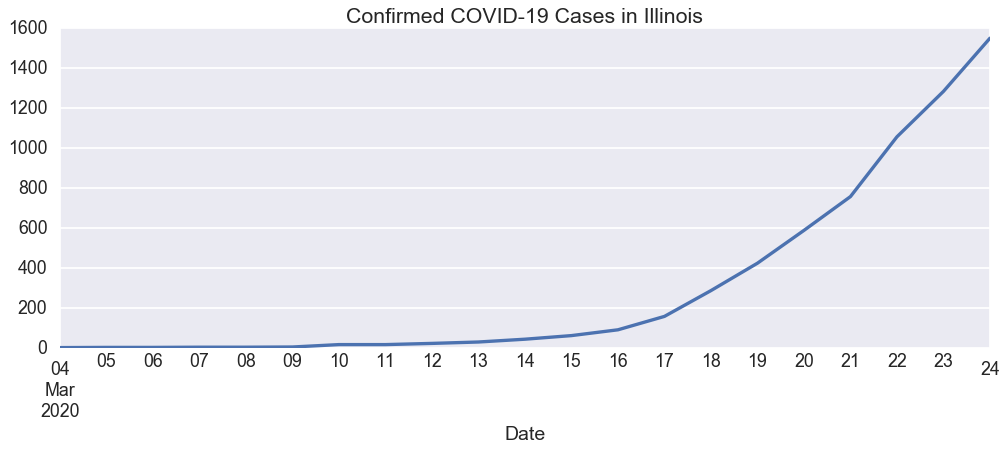

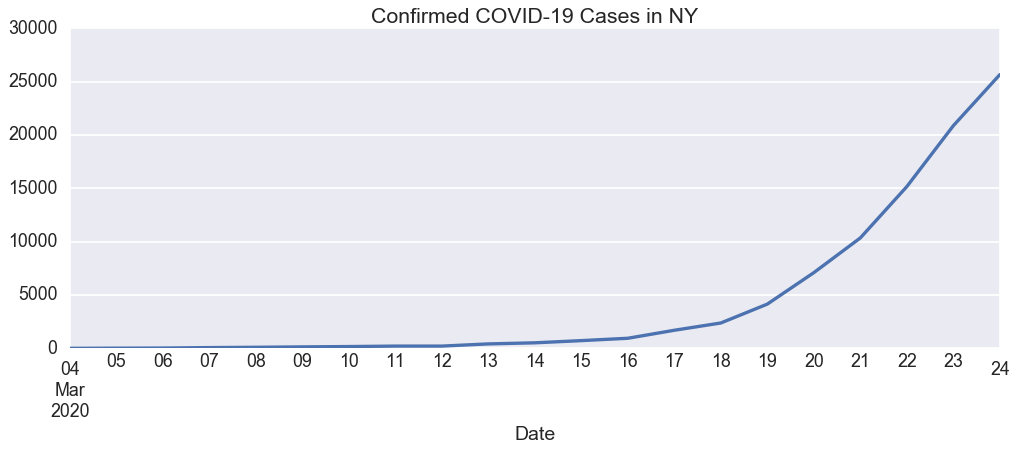

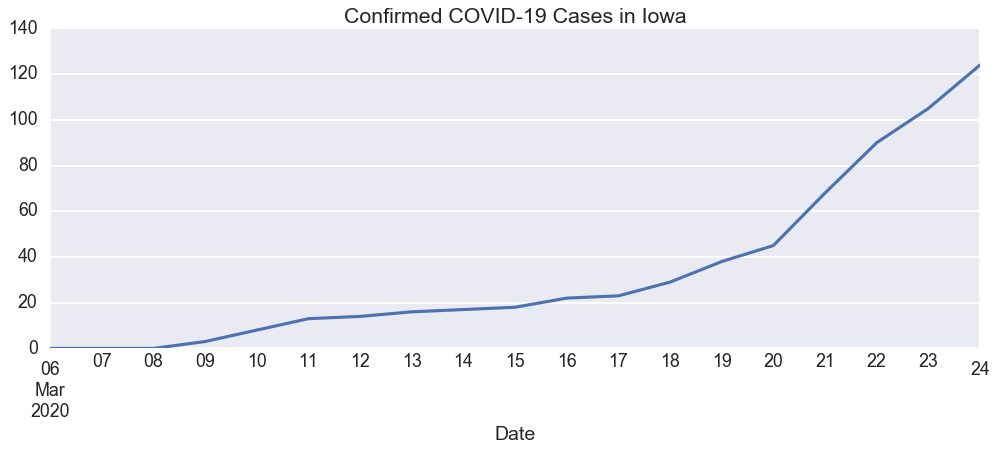

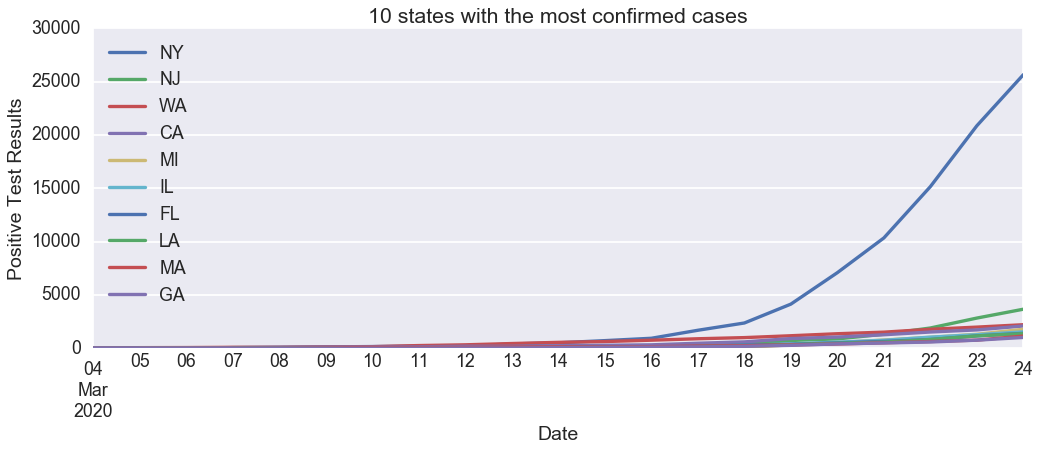

In [184]:
## Visualizations    
plt.style.use('seaborn-darkgrid')
with open('coronavirus.json') as f:
    plotting = json.load(f)

plotting = pd.DataFrame(plotting['daily_summary'])
plotting.set_index('Date', drop = True, inplace = True)

fig = plt.figure(figsize=(15,5))
grouped.Positive.plot(label = 'Positive', linewidth=3)
plt.title('Positive Test Results COVID-19')
fig.gca()
plt.show()
fig.savefig('images/positive_tests.png')

fig = plt.figure(figsize=(15,5))
grouped.Deaths.plot()
plt.title('US Deaths')
plt.show()
fig.savefig('images/deaths.png')

fig = plt.figure(figsize=(15,5))
grouped['diff'] = grouped.Positive.diff()
grouped['diff'].plot()
plt.title('Positive Case Growth')
plt.show()
fig.savefig('images/positive_case_growth.png')

fig = plt.figure(figsize=(15,5))
df[df.State == 'IL'].Positive.plot(linewidth=3)
plt.title('Confirmed COVID-19 Cases in Illinois')
plt.show()
fig.savefig('images/illinois_cases.png')

fig = plt.figure(figsize=(15,5))
df[(df.State == 'NY')].Positive.plot(linewidth=3)
plt.title('Confirmed COVID-19 Cases in NY');
plt.show()
fig.savefig('images/ny_cases.png')

fig = plt.figure(figsize=(15,5))
df[df.State == "IA"].Positive.plot()
plt.title('Confirmed COVID-19 Cases in Iowa')
plt.show()
fig.savefig('images/ia_cases.png')

top_ten = df.loc[df.index.max()].sort_values(by='Positive', ascending=False)[:10]
ten_states = top_ten.State
fig = plt.figure(figsize=(15,5))
for state in ten_states:
    df[df.State == state].Positive.plot(label = state, linewidth=3)
plt.title('10 states with the most confirmed cases')
plt.ylabel('Positive Test Results')
plt.legend(loc='upper left')
plt.show()
fig.savefig('images/top_ten_states.png')

mapping_df = df.loc[df.index.max()].groupby('State').sum()

fig = go.Figure(data=go.Choropleth(
    locations=mapping_df.index, # Spatial coordinates
    z = mapping_df['Positive'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Confirmed Cases",
))

fig.update_layout(
    title_text = 'COVID-19 Cases by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image('images/positive_cases_map.png')

today = df.loc[df.index.max()]
today = today.dropna(subset = ['Positive'])

today['positive_rate'] = today.Positive/today.Total

rates = today.sort_values(by='positive_rate', ascending = False)
rates = rates[['State', 'positive_rate', 'Deaths', 'Positive']]

rates = rates.set_index('State')



colors = [Color(pick_for=x).get_hex_l() for x in rates.index]

fig = go.Figure([go.Bar(x=rates.index, y=rates.positive_rate, marker_color=colors)])
fig.update_layout(
    title_text = 'Positive Test Rate',
    geo_scope='usa', # limite map scope to USA
)
fig.show()
fig.write_image('images/positive_test_rate.png')

rates['death_rate'] = rates.Deaths/rates.Positive

rates = rates.sort_values(by='death_rate', ascending=False)

fig = go.Figure([go.Bar(x=rates.index, y=rates.death_rate, marker_color=colors)])
fig.update_layout(
    title_text = 'Mortality Rate',
    geo_scope='usa', # limite map scope to USA
)
fig.show()
fig.write_image('images/mortality_rate.png')